In [20]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
from scipy import signal
from scipy import linalg

## Repo directory overview (17.02.26)

```
data/
├── 1m straight pipe y branch/
│   ├── clogged pipe, no noisy first obs.wav
│   ├── clogged pipe, no noisy.WAV
│   ├── free pipe, no noisy first obs.wav
│   └── free pipe, no noisy.WAV
│
└── 3m straight pipe/
    ├── baseline/
    │   └── 16_02/
    │       ├── 16_02_26_baseline(bad).WAV
    │       └── baseline.WAV
    │
    ├── Ø20w120/
    │   ├── 16_02/
    │   │   ├── pos1.WAV
    │   │   ├── pos2.WAV
    │   │   ├── pos3.WAV
    │   │   ├── pos4.WAV
    │   │   └── pos5.WAV
    │   │
    │   └── 16_02(bad batch)/
    │       ├── ZOOM0001.WAV
    │       ├── ZOOM0002.WAV
    │       ├── ZOOM0003.WAV
    │       ├── ZOOM0004.WAV
    │       └── ZOOM0005.WAV
    │
    ├── Ø20w40/
    │   └── 16_02/
    │       ├── pos1.WAV
    │       ├── pos2.WAV
    │       ├── pos3.WAV
    │       ├── pos4.WAV
    │       └── pos5.WAV
    │
    ├── Ø40w120/
    │   └── 16_02/
    │       ├── pos1.WAV
    │       ├── pos2.WAV
    │       ├── pos3.WAV
    │       ├── pos4.WAV
    │       └── pos5.WAV
    │
    └── Ø40w40/
        └── 16_02/
            ├── pos1.WAV
            ├── pos2.WAV
            ├── pos3.WAV
            ├── pos4.WAV
            └── pos5.WAV
```



# Data loading & feature extraction:


## Feature explanation
- diameter_mm (int) — the insert diameter (Ø)
- width_mm (int) — the insert width (w)
- position (int or str) — the measurement position (1–5, or actual distance)
- fs (int) — sampling frequency
- y (object) — the signal array (mono, 1D numpy array)



In [21]:
feature_list = []

In [22]:
master_dir = Path(r"data\3m straight pipe\first_test")

In [23]:
# Cell 2: parsing helpers (folder -> Ø,w) and file -> position
# Accept: Ø20w120  OR Ø20_w120  (case-insensitive w)
CONFIG_RE = re.compile(r"^Ø(?P<diameter>\d+)_?w(?P<width>\d+)$", re.IGNORECASE)

# Accept: pos1, Position_3, p5, etc. (first integer after 'pos' if present, else None)
POS_RE = re.compile(r"(?:pos|p)\s*[_-]?\s*(?P<pos>\d+)", re.IGNORECASE)

def parse_config(folder_name: str) -> tuple[int, int]:
    m = CONFIG_RE.match(folder_name)
    if not m:
        raise ValueError(f"Folder name '{folder_name}' does not match 'Ø{{diameter}}w{{width}}' or 'Ø{{diameter}}_w{{width}}'")
    return int(m.group("diameter")), int(m.group("width"))

def parse_position(file_path: Path) -> int | None:
    m = POS_RE.search(file_path.stem)
    if not m:
        return None
    return int(m.group("pos"))

In [24]:
# Cell 3: scan dataset and build a metadata-only DataFrame (no audio loaded yet)


def build_index_df(
    root: Path,
    exts=(".wav", ".flac", ".mp3", ".ogg", ".m4a"),
    baseline_names=("baseline",),
) -> tuple[pd.DataFrame, pd.DataFrame]:

    exp_rows = []
    baseline_rows = []

    for cfg_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        diameter_mm, width_mm = parse_config(cfg_dir.name)

        # Only process files directly inside each config folder
        for f in sorted(cfg_dir.iterdir()):
            if not (f.is_file() and f.suffix.lower() in exts):
                continue

            stem_lower = f.stem.lower()
            is_baseline = any(tok in stem_lower for tok in baseline_names)

            if is_baseline:
                baseline_rows.append({
                    "diameter_mm": diameter_mm,
                    "width_mm": width_mm,
                    "file_path": str(f),
                })
            else:
                pos = parse_position(f)
                if pos is None:
                    continue  # ignore non-baseline files without position
                exp_rows.append({
                    "diameter_mm": diameter_mm,
                    "width_mm": width_mm,
                    "position": pos,
                    "file_path": str(f),
                })

    exp_df = (
        pd.DataFrame(exp_rows)
        .sort_values(["diameter_mm", "width_mm", "position"])
        .reset_index(drop=True)
    )

    baseline_df = (
        pd.DataFrame(baseline_rows)
        .sort_values(["diameter_mm", "width_mm"])
        .reset_index(drop=True)
    )

    return exp_df, baseline_df


exp_df, baseline_df = build_index_df(master_dir)

exp_df.head()
#baseline_df.head()

,diameter_mm,width_mm,position,file_path
0,20,40,1,data\3m straight pipe\first_test\Ø20w40\pos1.WAV
1,20,40,2,data\3m straight pipe\first_test\Ø20w40\pos2.WAV
2,20,40,3,data\3m straight pipe\first_test\Ø20w40\pos3.WAV
3,20,40,4,data\3m straight pipe\first_test\Ø20w40\pos4.WAV
4,20,40,5,data\3m straight pipe\first_test\Ø20w40\pos5.WAV


In [25]:
# Cell 4: load audio for a given df

def attach_audio(df: pd.DataFrame) -> pd.DataFrame:
    xs = []
    fss = []

    for fp in df["file_path"]:
        x, fs = librosa.load(fp, sr=None, mono=False)

        if x.ndim == 1:
            x_mono = x
        else:
            x_mono = x[0]  # keep channel 0

        xs.append(x_mono.astype(np.float32))
        fss.append(int(fs))

    df = df.copy()
    df["fs"] = fss
    df["y"] = xs
    df["n_samples"] = df["y"].map(len)
    df["duration_s"] = df["n_samples"] / df["fs"]
    return df


exp_df = attach_audio(exp_df)
baseline_df = attach_audio(baseline_df)

baseline_df.head()


,diameter_mm,width_mm,file_path,fs,y,n_samples,duration_s
0,0,0,data\3m straight pipe\first_test\Ø0w0\baseline...,48000,"[-9.655952e-06, -7.1525574e-07, 2.8729439e-05,...",1575936,32.832


In [26]:
exp_df['n_samples']

0     1480064
1     1568448
2     1567296
3     1522624
4     1527744
5     1522624
6     1584384
7     1526912
8     1533696
9     1530048
10    1529152
11    1574720
12    1529408
13    1560704
14    1561536
15    1503168
16    1494464
17    1520064
18    1515840
19    1499712
Name: n_samples, dtype: int64

# Data treatment

In [27]:
#make all audio signals the same length by centering on a set amount on observations

def compute_target_length(df: pd.DataFrame, seconds_each_side: float = 2.0) -> int:
    if df["fs"].nunique() != 1:
        raise ValueError("Sampling frequencies differ.")

    fs = df["fs"].iloc[0]
    min_len = df["y"].map(len).min()
    trim_each_side = int(seconds_each_side * fs)

    desired_n_obs = min_len - 2 * trim_each_side

    if desired_n_obs <= 0:
        raise ValueError("Signals too short for requested trimming.")

    return desired_n_obs

def center_all_to_length(df: pd.DataFrame, target_length: int) -> pd.DataFrame:
    df = df.copy()

    def center_crop(y):
        current_length = len(y)
        if current_length < target_length:
            raise ValueError("Signal shorter than target length.")

        start = (current_length - target_length) // 2
        end = start + target_length
        return y[start:end]

    df["y_centered"] = df["y"].apply(center_crop)
    df["n_samples"] = target_length
    df["duration_s"] = target_length / df["fs"]

    return df

In [28]:
target_obs = compute_target_length(exp_df)
exp_df = center_all_to_length(exp_df, target_obs)
baseline_df = center_all_to_length(baseline_df, target_obs)

In [29]:
def check_signal_lengths(df: pd.DataFrame, signal_col: str = "y_centered") -> None:
    if signal_col not in df.columns:
        raise ValueError(f"Column '{signal_col}' not found in dataframe.")

    lengths = []
    problems = []

    for idx, row in df.iterrows():
        y = row[signal_col]

        if not isinstance(y, np.ndarray):
            problems.append((idx, "Not numpy array"))
            continue

        if y.ndim != 1:
            problems.append((idx, "Signal not 1D"))

        lengths.append(len(y))

        if "n_samples" in df.columns:
            if len(y) != row["n_samples"]:
                problems.append((idx, "Mismatch with n_samples"))

        if "fs" in df.columns and "duration_s" in df.columns:
            expected_duration = len(y) / row["fs"]
            if not np.isclose(expected_duration, row["duration_s"]):
                problems.append((idx, "Mismatch with duration_s"))

    unique_lengths = set(lengths)

    print(f"Rows checked: {len(df)}")
    print(f"Unique signal lengths: {unique_lengths}")

    if problems:
        print("Problems found:")
        for p in problems:
            print(p)
    else:
        print("All signals consistent.")

check_signal_lengths(exp_df)
check_signal_lengths(baseline_df)

Rows checked: 20
Unique signal lengths: {1288064}
All signals consistent.
Rows checked: 1
Unique signal lengths: {1288064}
All signals consistent.


# Feature engineering

## Standard sound driven features (play my pipes vol 1)

In [30]:
#Playing the pipes vol 1 features

def zcr(x,fs):
    return np.mean(librosa.zero_crossings(x))

def energy(x,fs):
    return scipy.linalg.norm(x)

def extract_mfcc(signal,fs):
    # n_mfcc=50 #<- this may be changed
    mfcc=librosa.feature.mfcc(y=signal, sr=fs)
    mfccs = np.mean(mfcc.T,axis=0)
    return mfccs

def extract_spectral_centroid(signal,fs):
    return np.mean(librosa.feature.spectral_centroid(y=signal, sr=fs))

def spec_bw(signal,fs):
    return np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=fs))

def extract_stft_mag(signal,fs):
    return np.mean(np.abs(librosa.amplitude_to_db(librosa.stft(signal,n_fft=2048,hop_length=512),ref=np.max)).T,axis=0)

def extract_stft_phase(signal,fs):
    return np.mean(librosa.feature.poly_features(S=np.angle(librosa.amplitude_to_db(librosa.stft(signal,n_fft=2048,hop_length=512),ref=np.max)),order=2).T,axis=0)

def chroma_stf(signal,fs):
    return np.mean(librosa.feature.chroma_stft(y=signal, sr=fs))

def rmse(signal,fs):
    return np.mean(librosa.feature.rms(y=signal))

def SpecRolloff(signal,fs):
    return np.mean(librosa.feature.spectral_rolloff(y=signal, sr=fs))

In [31]:
def apply_vol1_features(df: pd.DataFrame, feature_dict: dict, signal_col="y") -> pd.DataFrame:
    """
    feature_dict = {
        "zcr": zcr,
        "energy": energy,
        "mfcc": extract_mfcc,
        ...
    }
    """

    df = df.copy()

    for feature_name, func in feature_dict.items():
        feature_values = []

        for _, row in df.iterrows():
            y = row[signal_col]
            fs = row["fs"]
            value = func(y, fs)
            feature_values.append(value)

        # Handle scalar vs vector features
        if isinstance(feature_values[0], np.ndarray):
            arr = np.vstack(feature_values)
            for i in range(arr.shape[1]):
                df[f"{feature_name}_{i}"] = arr[:, i]
        else:
            df[feature_name] = feature_values

    return df

In [32]:
vol1_feature_dict = {
    "zcr": zcr,
    "energy": energy,
    "mfcc": extract_mfcc,
    "spectral_centroid": extract_spectral_centroid,
    "spectral_bw": spec_bw,
    "rmse": rmse,
    "rolloff": SpecRolloff
}

## Transfer function based features

In [33]:
def make_log_sweep(fs: int, duration_s: float, f_start: float, f_end: float) -> np.ndarray:
    """
    Returns a 1D numpy array: logarithmic chirp (log sweep).
    """
    t = np.arange(int(round(duration_s * fs))) / fs
    x = signal.chirp(t, f0=f_start, f1=f_end, t1=duration_s, method="logarithmic")
    x = x.astype(np.float32)
    return x

# Parameters (yours)
fs = int(exp_df["fs"].iloc[0])  # assumes single fs in exp_df
sweep_duration_s = 0.5
f_start = 100.0
f_end = 10_000.0

x_sweep = make_log_sweep(fs, sweep_duration_s, f_start, f_end)

len(x_sweep), x_sweep[:10]

(24000,
 array([1.        , 0.9999143 , 0.9996572 , 0.9992286 , 0.9986285 ,
        0.99785686, 0.9969138 , 0.9957993 , 0.9945135 , 0.9930565 ],
       dtype=float32))

fs: 48000
sweep samples: 24000
sweep duration (s): 0.5


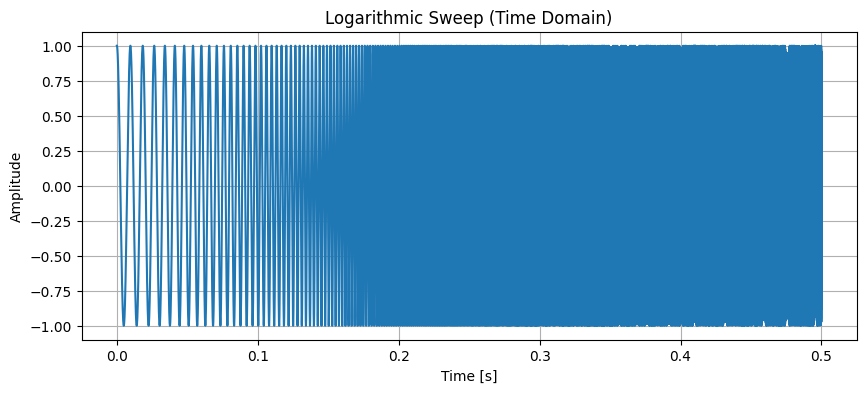

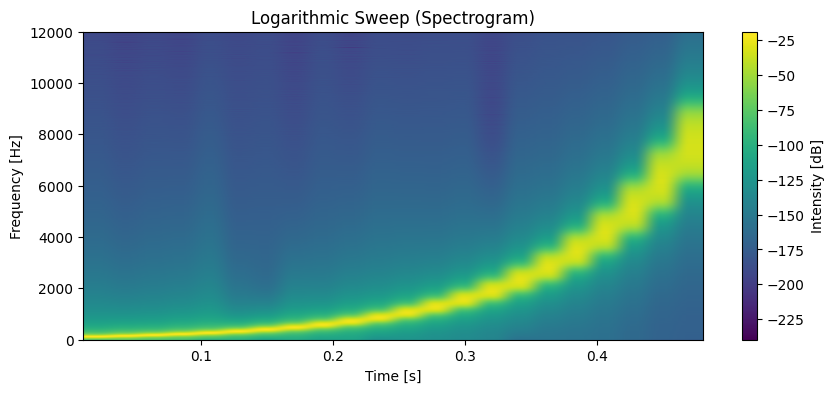

In [34]:
print("fs:", fs)
print("sweep samples:", len(x_sweep))
print("sweep duration (s):", len(x_sweep)/fs)

t = np.arange(len(x_sweep)) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, x_sweep)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Logarithmic Sweep (Time Domain)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.specgram(x_sweep, Fs=fs, NFFT=2048, noverlap=1024, cmap="viridis")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Logarithmic Sweep (Spectrogram)")
plt.ylim(0, 12000)
plt.colorbar(label="Intensity [dB]")
plt.show()

In [35]:
def find_sweep_start(y: np.ndarray, x_sweep: np.ndarray) -> int:
    """
    Returns the index in y that best matches the start of x_sweep (modulo periodic repeats).
    Uses matched filter via correlation. Works even if y starts mid-sweep.
    """
    y = np.asarray(y).ravel()
    x = np.asarray(x_sweep).ravel()

    # Normalize to reduce sensitivity to gain differences
    y0 = y - np.mean(y)
    x0 = x - np.mean(x)

    # Matched filter: correlate y with x
    corr = signal.fftconvolve(y0, x0[::-1], mode="valid")
    start = int(np.argmax(corr))
    return start

def segment_into_sweeps(y: np.ndarray, start: int, sweep_len: int):
    y2 = np.asarray(y).ravel()[start:]
    n = len(y2) // sweep_len
    y2 = y2[:n * sweep_len]
    return y2.reshape(n, sweep_len), n

In [36]:
def avg_mag_spectrum_from_sweeps(y, fs, x_sweep, nfft=None, max_sweeps=None, min_sweeps=5):
    sweep_len = len(x_sweep)
    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(sweep_len)))

    start = find_sweep_start(y, x_sweep)
    sweeps, n = segment_into_sweeps(y, start, sweep_len)

    if n < min_sweeps:
        raise ValueError(f"Only {n} full sweeps found; need at least {min_sweeps}.")

    if max_sweeps is not None:
        sweeps = sweeps[:max_sweeps]
        n = sweeps.shape[0]

    win = np.hanning(sweep_len).astype(np.float32)
    Y = np.fft.rfft(sweeps * win[None, :], n=nfft, axis=1)
    mag_mean = np.abs(Y).mean(axis=0)
    f = np.fft.rfftfreq(nfft, d=1/fs)

    return f, mag_mean, n

In [37]:
def relative_mag_db(exp_y: np.ndarray, base_y: np.ndarray, fs: int, x_sweep: np.ndarray,
                    nfft=None, max_sweeps=None, min_sweeps=5):
    f, mag_exp, n_exp = avg_mag_spectrum_from_sweeps(
        exp_y, fs, x_sweep, nfft=nfft, max_sweeps=max_sweeps, min_sweeps=min_sweeps
    )
    f2, mag_base, n_base = avg_mag_spectrum_from_sweeps(
        base_y, fs, x_sweep, nfft=nfft, max_sweeps=max_sweeps, min_sweeps=min_sweeps
    )

    if not np.allclose(f, f2):
        raise ValueError("Frequency grids differ. Use same nfft settings.")

    eps = 1e-12
    M_rel = 20.0 * np.log10((mag_exp + eps) / (mag_base + eps))
    return f, M_rel, n_exp, n_base

In [38]:
f_base, mag_base, n_base = avg_mag_spectrum_from_sweeps(base_y, fs, x_sweep, min_sweeps=5)

f_list = []
Mrel_list = []
nexp_list = []

for y in exp_df["y"]:
    f, mag_exp, n_exp = avg_mag_spectrum_from_sweeps(y, fs, x_sweep, min_sweeps=5)
    if not np.allclose(f, f_base):
        raise ValueError("Frequency grids differ. Use same nfft settings.")
    Mrel = 20.0 * np.log10((mag_exp + 1e-12) / (mag_base + 1e-12))
    f_list.append(f)
    Mrel_list.append(Mrel)
    nexp_list.append(n_exp)

exp_df = exp_df.copy()
exp_df["f"] = f_list
exp_df["M_rel_db"] = Mrel_list
exp_df["n_sweeps_used"] = nexp_list
exp_df["n_sweeps_used_baseline"] = n_base

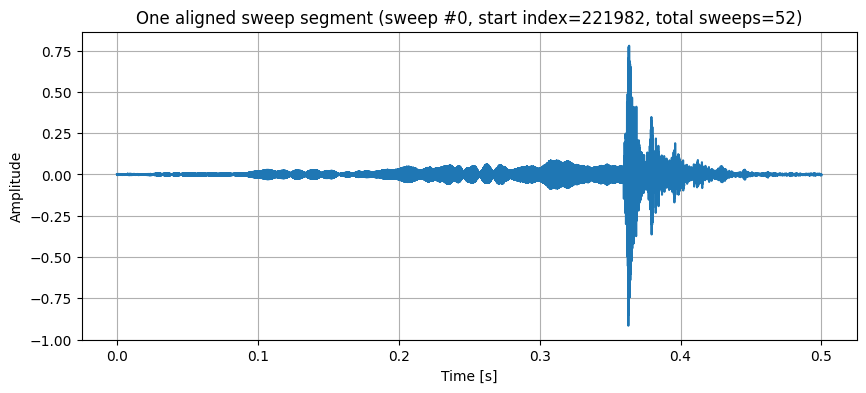

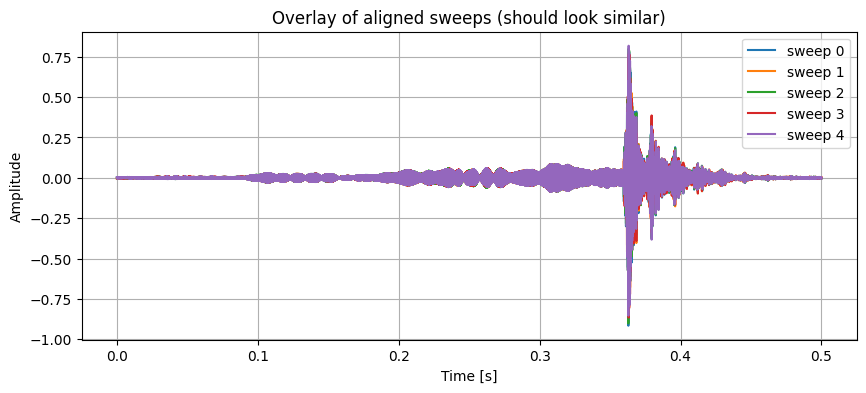

In [39]:
#test

def plot_aligned_sweeps(y: np.ndarray, fs: int, x_sweep: np.ndarray,
                        n_show: int = 3, start_sweep: int = 0):
    sweep_len = len(x_sweep)

    start = find_sweep_start(y, x_sweep)
    sweeps, n = segment_into_sweeps(y, start, sweep_len)  # your modified version returning (sweeps, n)

    # choose subset
    end_sweep = min(start_sweep + n_show, n)
    sweeps_show = sweeps[start_sweep:end_sweep]

    t = np.arange(sweep_len) / fs

    # Plot first selected sweep
    plt.figure(figsize=(10, 4))
    plt.plot(t, sweeps_show[0])
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"One aligned sweep segment (sweep #{start_sweep}, start index={start}, total sweeps={n})")
    plt.grid(True)
    plt.show()

    # Overlay a few sweeps to check consistency
    plt.figure(figsize=(10, 4))
    for i, s in enumerate(sweeps_show):
        plt.plot(t, s, label=f"sweep {start_sweep+i}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Overlay of aligned sweeps (should look similar)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example: plot from first experiment row
fs = int(exp_df["fs"].iloc[0])
y0 = exp_df.iloc[0]["y"]

plot_aligned_sweeps(y0, fs, x_sweep, n_show=5, start_sweep=0)